In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from fbpinns.util.logger import logger
from fbpinns.domains import RectangularDomainND
from fbpinns.problems import Problem
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN,AdaptiveFCN,FourierFCN
from fbpinns import networks
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer, PINNTrainer,PINN_model_jit,FBPINN_model_jit,get_inputs
from fbpinns.traditional_solutions.seismic_cpml.seismic_CPML_2D_pressure_second_order import seismicCPML2D
import time
import matplotlib.pyplot as plt
from fbpinns.traditional_solutions.seismic_cpml.seismic_CPML_helper import get_dampening_profiles
import jax.numpy as jnp
import pickle
from fbpinns.util.other import DictToObj
from fbpinns.analysis import load_model
from fbpinns.analysis import FBPINN_solution as FBPINN_solution_
from fbpinns.analysis import PINN_solution as PINN_solution_
from jax import device_get
from fbpinns.schedulers import PlaneSchedulerRectangularND,PointSchedulerRectangularND

In [247]:
class WaveEquation3D(Problem):
    """Solves the time-dependent (2+1)D wave equation with constant velocity
        d^2 u   d^2 u    1  d^2 u
        ----- + ----- - --- ----- = s(x,y,t)
        dx^2    dy^2    c^2 dt^2

        Boundary conditions:
        u(x,y,0) = 0
        du
        --(x,y,0) = 0
        dt
    """

    @staticmethod
    def init_params(c0=1,c1=3, sd=0.04,source=np.array([[-0.5,-0.3,0.1,1.0]])):

        static_params = {
            "dims":(1,3),
            "c0":c0,
            "c1":c1,
            "c_fn":WaveEquation3D.c_fn,
            "source":jnp.array(source),
            "sd":sd,
            }
        return static_params, {}

    @staticmethod
    def c_fn(all_params, x_batch):
        "Computes the velocity model"
    
        p = all_params["static"]["problem"]
        c0, c1 = p["c0"], p["c1"]
    
        x = x_batch[:,0:1]
        c = c0 + (c1-c0)*(1+jnp.tanh(x/0.1))/2
       
        return c

    @staticmethod
    def c_fn2(all_params,x_batch):
     
         
        x, y = x_batch[:,0:1], x_batch[:,1:2] 
    
        # Define velocity parameters (in km/s)
        v1, v2, v3 = 1.5, 2.5, 3.5  # Baseline velocities (km/s)
        A1, A2, A3 = 0.2, 0.15, 0.1  # Amplitudes of velocity variations (km/s)
        k1, k2, k3 = 2 * jnp.pi / 2, 2 * jnp.pi / 3, 2 * jnp.pi / 4  # Adjusted wavenumbers
        phi1, phi2, phi3 = 0, jnp.pi / 4, jnp.pi / 2  # Phase shifts
    
        # Define wavy layer boundaries
        z1 = 0.0 + 0.5 * jnp.sin(k1 * y + k1 * x + phi1)  # Wavy boundary for z1
        z2 = 0.5 + 0.5 * jnp.sin(k2 * y + k2 * x + phi2)  # Wavy boundary for z2
    
        # Compute velocity based on the layer
        velocity = jnp.where(x < z1, 
                            v1 + A1 * jnp.sin(k1 * y + k1 * x + phi1 ),  # Layer 1
                            jnp.where(x < z2, 
                                     v2 + A2 * jnp.sin(k2 * y + k2 * x + phi2  ),  # Layer 2
                                     v3 + A3 * jnp.sin(k3 * y + k3 * x + phi3 )))  # Layer 3
        

        velocity = velocity.flatten()
        
        velocity = iterative_gaussian_smoothing(velocity, 10, 10)  # Perform smoothing
        
                
        return velocity
 


    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):

        # physics loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0,(0,0)),
            (0,(1,1)),
            (0,(2,2)),
        )
        return [[x_batch_phys, required_ujs_phys],]
        return s

    @staticmethod
    def constraining_fn(all_params, x_batch, u):
        c0 = all_params["static"]["problem"]["c0"]
        sd = all_params["static"]["problem"]["sd"]
        t = x_batch[:,2:3]

        u = (jax.nn.tanh(c0*t/(2*sd))**2)*u# constrains u(x,y,0) = u_t(x,y,0) = 0
        return u

    @staticmethod
    def loss_fn(all_params, constraints):
        params = all_params["static"]["problem"]
        c0, source = params["c0"], params["source"]
        c_fn = params["c_fn"]
        sd = all_params["static"]["problem"]["sd"]
        x_batch, uxx, uyy, utt = constraints[0]
        x, y, t = x_batch[:,0:1], x_batch[:,1:2], x_batch[:,2:3]
        
        sd = 0.04
             
         
    
        #x, t = x_batch[:,0:2], x_batch[:,2:3]
        tanh, exp = jax.nn.tanh, jnp.exp
        
        # get starting wavefield
        #p = jnp.expand_dims(source, axis=1)# (k, 1, 4)
        #x = jnp.expand_dims(x, axis=0)# (1, n, 2)
        #f1 = (p[:,:,3:4]*exp(-0.5 * ((x-p[:,:,0:2])**2).sum(2, keepdims=True)/(p[:,:,2:3]**2))).sum(0)# (n, 1)
        
        #t1 = source[:,2].min()/c0
        #f2 = exp(-0.5*(1.5*t/t1)**2) * f1


  
        e = -0.5*((x+0.7)**2 + (y)**2 + t**2)/(sd**2)
        s = 2e3*(1+e)*jnp.exp(e)# ricker source term
        #c,_,_ = extract_from_npz(npz_path, nx=80, ny=80, nt=80, for_pinn=True)
        
        c = resample_velocity_field('./marmousi_combined.npz', 80, 80,80).flatten().reshape(-1,1)
         
        c     =  jnp.array(c) 
         
        
        
        
        
        #phys = (uxx + uyy) - (1/c_fn(all_params, x_batch)**2)*utt - s
        phys = (uxx + uyy) - (1/c**2)*utt- s
        
        return jnp.mean(phys**2)
     
    @staticmethod
    def exact_solution1(all_params, x_batch, batch_shape):
        key = jax.random.PRNGKey(0)
        return jax.random.normal(key, (x_batch.shape[0],1))


    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape):

        # use the seismicCPML2D FD code with very fine sampling to compute solution

        params = all_params["static"]["problem"]
        c0, source = params["c0"], params["source"]
        c_fn = params["c_fn"]
        sd = all_params["static"]["problem"]["sd"]
        (xmin, ymin, tmin), (xmax, ymax, tmax) = np.array(x_batch.min(0)), np.array(x_batch.max(0))

        # get grid spacing
        deltax, deltay, deltat = (xmax-xmin)/(batch_shape[0]-1), (ymax-ymin)/(batch_shape[1]-1), (tmax-tmin)/(batch_shape[2]-1)

        # get f0, target deltas of FD simulation
        f0 = c0/source[:,2].min()# approximate frequency of wave
        DELTAX = DELTAY = 1/(f0*20)# target fine sampled deltas
        DELTAT = DELTAX / (4*np.sqrt(2)*1.5)# target fine sampled deltas
        dx, dy, dt = int(np.ceil(deltax/DELTAX)), int(np.ceil(deltay/DELTAY)), int(np.ceil(deltat/DELTAT))# make sure deltas are a multiple of test deltas
        DELTAX, DELTAY, DELTAT = deltax/dx, deltay/dy, deltat/dt
        NX, NY, NSTEPS = batch_shape[0]*dx-(dx-1), batch_shape[1]*dy-(dy-1), batch_shape[2]*dt-(dt-1)

        # get starting wavefield
        xx,yy = np.meshgrid(np.linspace(xmin, xmax, NX), np.linspace(ymin, ymax, NY), indexing="ij")# (NX, NY)
        x = np.stack([xx.ravel(), yy.ravel()], axis=1)# (n, 2)
        exp = np.exp
        p = np.expand_dims(source, axis=1)# (k, 1, 4)
        x = np.expand_dims(x, axis=0)# (1, n, 2)
        f = (p[:,:,3:4]*exp(-0.5 * ((x-p[:,:,0:2])**2).sum(2, keepdims=True)/(sd**2))).sum(0)# (n, 1)
        p0 = f.reshape((NX, NY))
        p0_ = f.reshape((NX,NY))*0

          # get velocity model
        x = np.stack([xx.ravel(), yy.ravel()], axis=1)# (n, 2)
        c = np.array(c_fn(all_params, x))
        if c.shape[0]>1: c = c.reshape((NX, NY))
        else: c = c*np.ones_like(xx)
 
        
                # get starting wavefield
        xx,yy,tt = np.meshgrid(np.linspace(xmin, xmax, NX), np.linspace(ymin, ymax, NY),np.linspace(tmin,tmax,NSTEPS), indexing="ij")# (NX, NY)
        xdbatch = np.stack([xx.ravel(), yy.ravel(),tt.ravel()], axis=1)# (n, 2)
        exp = np.exp
        
        x,y,t = xdbatch[:,0:1],xdbatch[:,1:2],xdbatch[:,2:3]
        #x = np.expand_dims(x, axis=0)# (1, n, 2)
        #f = (p[:,:,3:4]*exp(-0.5 * ((x-p[:,:,0:2])**2).sum(2, keepdims=True)/(p[:,:,2:3]**2))).sum(0)# (n, 1)
        #t1 = source[:,2].min()/c0
        #ff = 1000*exp(-0.5*(1.5*t/t1)**2) * f
        sd = 0.04
        e = -0.5*((x+0.7)**2 + (y)**2 + t**2)/(sd**2)
        s = 2e3*(1+e)*jnp.exp(e)# ricker source term
         
         
        ff = s.reshape(NX,NY,NSTEPS)
        src = np.moveaxis(ff,-1,0) 
        density = 1.0 * np.ones((NX, NY))


        #MarmousI smooth Velocity model
        #vel,_,_= extract_from_npz(npz_path, nx=NX, ny=NY, for_pinn=False)
        vel = resample_velocity_field('./vmodel8.npy', NX, NY)/1000
      
        # add padded CPML boundary
        NPOINTS_PML = 10
        p0_ = np.pad(p0_, [(NPOINTS_PML,NPOINTS_PML),(NPOINTS_PML,NPOINTS_PML)], mode="edge")
        
        
        
        c =   np.pad(vel, [(NPOINTS_PML,NPOINTS_PML),(NPOINTS_PML,NPOINTS_PML)], mode="edge")
        density =  np.pad(density, [(NPOINTS_PML,NPOINTS_PML),(NPOINTS_PML,NPOINTS_PML)], mode="edge")
        source_array =  np.pad(src, [(0, 0), (NPOINTS_PML,NPOINTS_PML), (NPOINTS_PML, NPOINTS_PML)], mode='edge')
        # run simulation
        logger.info(f'Running seismicCPML2D {(NX, NY, NSTEPS)}..')
        
        wavefields,_ = run_seismic_simulation_src(
        NX+2*NPOINTS_PML, NY+2*NPOINTS_PML, NSTEPS, DELTAX, DELTAY, DELTAT, NPOINTS_PML,
        c, np.ones((NX+2*NPOINTS_PML,NY+2*NPOINTS_PML)), (p0_.copy(),p0_.copy()), dtype=np.float32,
        save_wavefields=True, gather_points=None, source=source_array)
        
        #normalize
        #wavefields = (wavefields - np.min(wavefields)) / (np.max(wavefields) - np.min(wavefields))
        # get croped, decimated, flattened wavefields
        wavefields = wavefields[:,NPOINTS_PML:-NPOINTS_PML,NPOINTS_PML:-NPOINTS_PML]
        wavefields = wavefields[::dt, ::dx, ::dy]
        wavefields = np.moveaxis(wavefields, 0, -1)
        assert wavefields.shape == batch_shape
        u = wavefields.reshape((-1, 1))
         
         
        return u



In [198]:

subdomain_xs = [np.linspace(-1,1,4), np.linspace(-1,1,4), np.linspace(0,1,4)]
subdomain_ws = get_subdomain_ws(subdomain_xs, 1.9)
xd = len(subdomain_xs)
c = Constants(
    run="test",
    domain=RectangularDomainND,
    domain_init_kwargs=dict(
        xmin=np.array([-1,-1,0]),
        xmax=np.array([1,1,1]),
    ),
    problem=WaveEquation3D,
    problem_init_kwargs=dict(
        c0=1,c1=3, sd=0.02,
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=subdomain_ws,
        unnorm=(0.,1.),
    ),
    network= FourierFCN,
    network_init_kwargs=dict(
        layer_sizes=[3,32,16,1],
        
    ),
    #scheduler = PointSchedulerRectangularND,
    #scheduler_kwargs = dict(
     #   point = [-1,-1,0], ),
    ns=((80,80,80),),
    n_test=(60,60,10),
    n_steps= 120000,
    optimiser_kwargs=dict(learning_rate=1e-3),
    summary_freq=1000,
    test_freq=200,
    show_figures=True,
    clear_output=True,
)


c["network_init_kwargs"] = dict(layer_sizes=[3,64,64,64,1],mu= 0,sd=1,n_features=200)
#c["network_init_kwargs"] = dict(layer_sizes=[3,64,64,64,1])


In [321]:
c = resample_velocity_field('./marmousi_combined.npz', 80, 80,80).flatten().reshape(-1,1)
c.shape

(512000, 1)

In [199]:
run = PINNTrainer(c)
all_params,loss_log,x_batch_test,model_fns = run.train()
np.save("/home/bharath/Desktop/tfb/MARMamousi_FOURIER.npy",loss_log)

[INFO] 2025-01-13 20:53:00 - <fbpinns.constants.Constants object at 0x70e578018cb0>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([-1, -1,  0]), 'xmax': array([1, 1, 1])}
problem: <class '__main__.WaveEquation3D'>
problem_init_kwargs: {'c0': 1, 'c1': 3, 'sd': 0.02}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([-1.        , -0.33333333,  0.33333333,  1.        ]), array([-1.        , -0.33333333,  0.33333333,  1.        ]), array([0.        , 0.33333333, 0.66666667, 1.        ])], 'subdomain_ws': [array([1.26666667, 1.26666667, 1.26666667, 1.26666667]), array([1.26666667, 1.26666667, 1.26666667, 1.26666667]), array([0.63333333, 0.63333333, 0.63333333, 0.63333333])], 'unnorm': (0.0, 1.0)}
network: <class 'fbpinns.networks.FourierFCN'>
network_init_kwargs: {'layer_sizes': [3, 64, 64, 64, 1], 'mu': 0, 'sd': 1, 'n_features': 200}
n_steps: 120000
scheduler: <c

KeyboardInterrupt: 

In [15]:
np.save("/home/bharath/Desktop/tfb/loss_pinn_src_marm_smooth",loss_log2)

In [194]:
run = FBPINNTrainer(c)
all_params1,loss_log1,x_batch_test1,model_fns1= run.train()
np.save("/home/bharath/Desktop/tfb/MARMamousi_fbpinn.npy",loss_log1)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x70e60017d760> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [206]:
loss_log_p2 = np.load("/home/bharath/Desktop/tfb/loss_pinn_vel_8_smooth_trans.npy")
loss_log_f2 = np.load("/home/bharath/Desktop/tfb/loss_fbpinn_src_2_complex_new_No_scheduling_1.npy")
loss_log_ff2 = np.load("/home/bharath/Desktop/tfb/fourier_sd_2.npy")
loss_log_p1 = np.load("/home/bharath/Desktop/tfb/loss_pinn_src_new_func120k_2_ricker_2layered.npy")
loss_log_f1 = np.load("/home/bharath/Desktop/tfb/loss_fbpinn_src_2_layered.npy")
loss_log_ff1 = np.load("/home/bharath/Desktop/tfb/loss_pinn_src_fourier200_scheduling.npy")
loss_log_p3 = np.load("/home/bharath/Desktop/tfb/MARMamousi_PINN.npy")
loss_log_f3 = np.load("/home/bharath/Desktop/tfb/loss_fbpinn_src_marm_120_smooth_gaussian.npy")
loss_log_ff3 = np.load("/home/bharath/Desktop/tfb/MARMamousi_FOURIER.npy")

In [ ]:
loss_log_p = np.load("/home/bharath/Desktop/tfb/MARMamousi_PINN.npy")
loss_log_f = np.load("/home/bharath/Desktop/tfb/MARMamousi_FOURIER.npy")
#loss_log_ff = np.load("/home/bharath/Desktop/tfb/fourier_sd_2.npy")


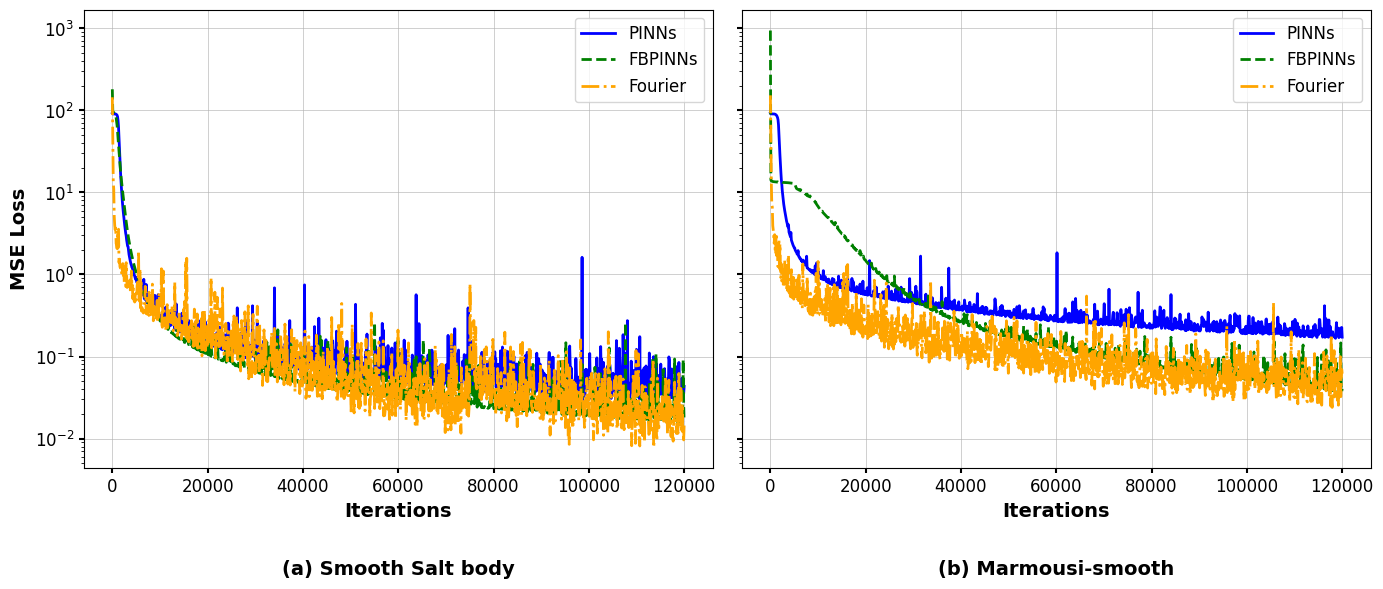

In [281]:
import matplotlib.pyplot as plt
import numpy as np

# Define iterations (1200 samples representing 120,000 iterations)
iterations = np.linspace(0, 120000, len(loss_log_p1))

# Create subplots with shared y-axis
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for the first set of data
axes[0].plot(iterations, loss_log_p2, label='PINNs', linestyle='-', color='blue', linewidth=2)
axes[0].plot(iterations, loss_log_f2, label='FBPINNs', linestyle='--', color='green', linewidth=2)
axes[0].plot(iterations, loss_log_ff2, label='Fourier', linestyle='-.', color='orange', linewidth=2)
axes[0].set_yscale('log')
axes[0].set_xlabel('Iterations', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MSE Loss', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.6, linewidth=0.7)
axes[0].legend(fontsize=12, loc='best')
axes[0].tick_params(axis='both', which='major', labelsize=12, width=1.5)
axes[0].text(0.5, -0.2, '(a) Smooth Salt body', fontsize=14, fontweight='bold', ha='center', va='top', transform=axes[0].transAxes)

# Plot for the second set of data
axes[1].plot(iterations, loss_log_p3, label='PINNs', linestyle='-', color='blue', linewidth=2)
axes[1].plot(iterations, loss_log_f3, label='FBPINNs', linestyle='--', color='green', linewidth=2)
axes[1].plot(iterations, loss_log_ff3, label='Fourier', linestyle='-.', color='orange', linewidth=2)
axes[1].set_yscale('log')
axes[1].set_xlabel('Iterations', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.6, linewidth=0.7)
axes[1].legend(fontsize=12, loc='best')
axes[1].tick_params(axis='both', which='major', labelsize=12, width=1.5)
axes[1].text(0.5, -0.2, '(b) Marmousi-smooth', fontsize=14, fontweight='bold', ha='center', va='top', transform=axes[1].transAxes)

# Adjust layout for clarity
plt.tight_layout()

# Save the plot as a high-resolution image
plt.savefig('side_by_side_training_loss_with_titles_ONLY_2.png', dpi=300, bbox_inches='tight')

# Show the plots
plt.show()


In [32]:

u_test,u_raw_test= PINN_model_jit(all_params,x_batch_test,model_fns,verbose=True)
u_test = u_test.reshape(60,60,10)

[INFO] 2025-01-09 11:01:59 - x_batch
[INFO] 2025-01-09 11:01:59 - (36000, 3), float32, DynamicJaxprTracer


 # TEST STARTS HERE
 

# PINN LOADING AND INFERENCE

In [10]:
import jax.numpy as jnp
import pickle
from fbpinns.util.other import DictToObj
from fbpinns.analysis import load_model
from fbpinns.analysis import FBPINN_solution as FBPINN_solution_
from fbpinns.analysis import PINN_solution as PINN_solution_

In [270]:
with open("./results_marm_pinn/summaries/test/constants_test.pickle", "rb") as f:
    c_dict = pickle.load(f)
    c = DictToObj(**c_dict, copy=True)

with open('./results_marm_pinn//models/test/model_00120000.jax', "rb") as f:
    model = pickle.load(f)

# convert np arrays to jax
model = jax.tree_util.tree_map(lambda x: jnp.array(x) if isinstance(x, np.ndarray) else x, model)

i, all_params,all_opt_states, u_test_losses = model

domain, problem, network = c.domain, c.problem, c.network

# define unnorm function
mu_, sd_ = c.decomposition_init_kwargs["unnorm"]
unnorm_fn = lambda u: networks.unnorm(mu_, sd_, u)

model_fns = (domain.norm_fn, network.network_fn, unnorm_fn, problem.constraining_fn)

u_test1, *_ = PINN_model_jit(all_params, x_batch, model_fns)
pinn = u_test1.reshape(60,60,10)

[INFO] 2025-01-15 14:58:47 - x_batch
[INFO] 2025-01-15 14:58:47 - (36000, 3), float32, DynamicJaxprTracer


### FFN_LOADING


In [271]:
with open("./results_marm_fourier//summaries/test/constants_test.pickle", "rb") as f:
    c_dict = pickle.load(f)
    c = DictToObj(**c_dict, copy=True)

with open('./results_marm_fourier//models/test/model_00120000.jax', "rb") as f:
    model = pickle.load(f)

# convert np arrays to jax
model = jax.tree_util.tree_map(lambda x: jnp.array(x) if isinstance(x, np.ndarray) else x, model)

i, all_params,all_opt_states, u_test_losses = model

domain, problem, network = c.domain, c.problem, c.network

# define unnorm function
mu_, sd_ = c.decomposition_init_kwargs["unnorm"]
unnorm_fn = lambda u: networks.unnorm(mu_, sd_, u)

model_fns = (domain.norm_fn, network.network_fn, unnorm_fn, problem.constraining_fn)

u_testf, *_ = PINN_model_jit(all_params, x_batch, model_fns)
fourier = u_testf.reshape(60,60,10)

[INFO] 2025-01-15 14:59:04 - x_batch
[INFO] 2025-01-15 14:59:04 - (36000, 3), float32, DynamicJaxprTracer


# FBPINN Loading and Inference

In [272]:
with open("./results_marm_fbpinn//summaries/test/constants_test.pickle", "rb") as f:
    c_dict = pickle.load(f)
    c = DictToObj(**c_dict, copy=True)
    
with open('./results_marm_fbpinn//models/test/model_00120000.jax', "rb") as f:
    model = pickle.load(f)

# convert np arrays to jax
model = jax.tree_util.tree_map(lambda x: jnp.array(x) if isinstance(x, np.ndarray) else x, model)
i, all_params, all_opt_states, active, u_test_losses = model

problem, decomposition, network = c.problem, c.decomposition, c.network

model_fns = (decomposition.norm_fn, network.network_fn, decomposition.unnorm_fn, decomposition.window_fn, problem.constraining_fn)

takes, _, (_, _, _, cut_all, _) = get_inputs(x_batch, active, all_params, c.decomposition)

all_params_cut = {"static":cut_all(all_params["static"]),
                  "trainable":cut_all(all_params["trainable"])}

u_test2_n2,*_ = FBPINN_model_jit(all_params_cut, x_batch, takes, model_fns)
 
fbpinn=u_test2_n2.reshape(60,60,10)

[INFO] 2025-01-15 14:59:27 - x_batch
[INFO] 2025-01-15 14:59:27 - (36000, 3), float32, DynamicJaxprTracer
[INFO] 2025-01-15 14:59:27 - x_take
[INFO] 2025-01-15 14:59:27 - (207936, 3), float32, DynamicJaxprTracer


In [190]:
pinn.shape,fbpinn.shape,fourier.shape

((60, 60, 10), (60, 60, 10), (60, 60, 10))

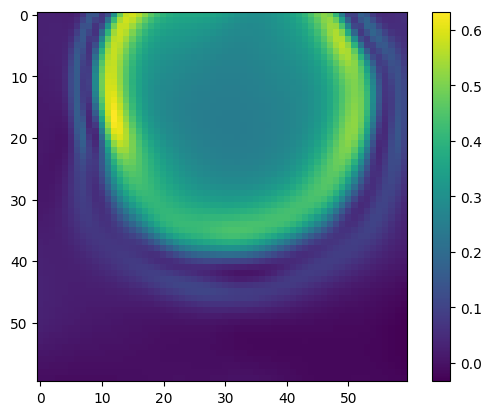

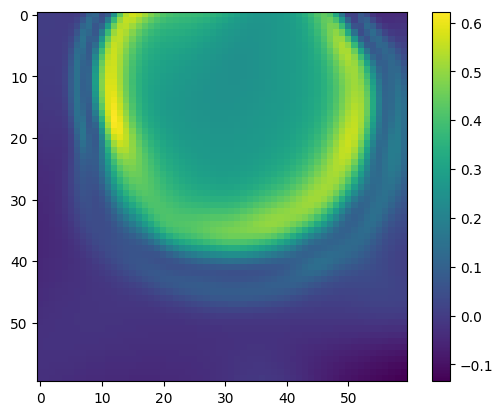

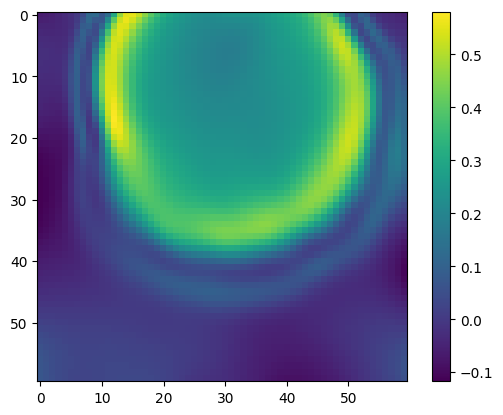

In [273]:
plt.figure()
plt.imshow(pinn[:,:,4])
plt.colorbar()
plt.figure()
plt.imshow(fbpinn[:,:,4])
plt.colorbar()
plt.figure()
plt.imshow(fourier[:,:,4])
plt.colorbar()

##  Analytical Testing

(60, 60, 10)

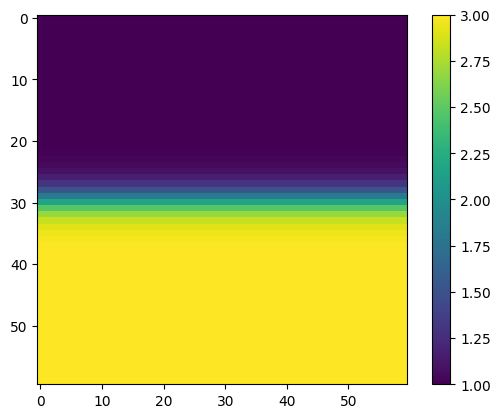

In [248]:

#_______________________________________________

 
problem = WaveEquation3D
kwargs = dict(sd=0.04)
 
 
 
ps_ = problem.init_params(**kwargs)
all_params = {"static":{"problem":ps_[0]}, "trainable":{"problem":ps_[1]}}
batch_shape = (60,60,10)
x_batch = RectangularDomainND._rectangle_samplerND(None, "grid", np.array([-1, -1, 0]), 
                                                   np.array([1, 1, 1]), batch_shape)
plt.figure()
c_ = np.array(problem.c_fn(all_params, x_batch))
c_= c_.reshape(batch_shape)

plt.imshow(c_[:,:,9])
plt.colorbar()
c_.shape

In [249]:
u_sb= problem.exact_solution(all_params, x_batch, batch_shape) 
u_sb = u_sb.reshape(batch_shape)

[INFO] 2025-01-15 14:40:11 - Running seismicCPML2D (414, 414, 1702)..
[Step 1000/1702] 0.00 s per step


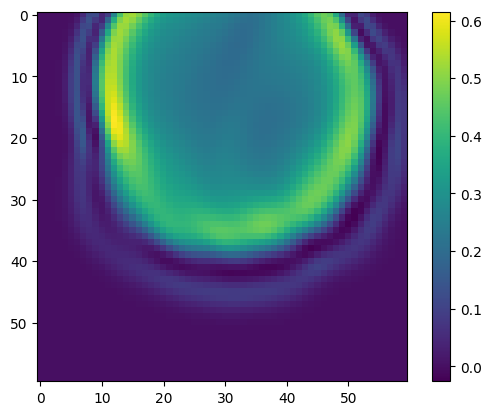

In [274]:
plt.figure()
plt.imshow(u_marm[:,:,4])
plt.colorbar()
 

In [49]:
u_test2_n2 = jnp.where(u_test2_n2 < 0, 0, u_test2)


In [267]:
import matplotlib.pyplot as plt

def plot_seismic_slices_extended(
    u_testFCN, u_fbPINN, u_fourier, u, vel_model,
    interpolation='none', cmap='viridis', save_path=None, dpi=600
):
    """
    Function to create subplots showing specific timesteps from the provided arrays.
    """
    slices = [1, 3, 4]  # Indices for timesteps to plot
    num_slices = len(slices)
    time_steps = [round(i * (1 / 10), 2) for i in slices]  # Calculate time values for slices

    # Create subplots with 7 rows and num_slices columns
    fig, axs = plt.subplots(7, num_slices, figsize=(10, 20), sharex=True, sharey=True)

    # Order of data for plotting
    plot_order = [
        ("FDM", u),
        ("PINN", u_testFCN),
        ("FDM - PINN", u_testFCN - u),
        ("FBPINN", u_fbPINN),
        ("FDM - FBPINN", u_fbPINN - u),
        ("Fourier", u_fourier),
        ("FDM - Fourier", u_fourier - u ),
    ]

    for row, (title, data) in enumerate(plot_order):  # Iterate through rows and data
        for col, slice_idx in enumerate(slices):  # Iterate through selected slices
            im = axs[row, col].imshow(vel_model, cmap='gray', alpha=0.5, interpolation=interpolation)
            im_sol = axs[row, col].imshow(
                data[:, :, slice_idx],
                cmap=cmap, alpha=0.8 if "-" in title else 0.6, interpolation=interpolation
            )
            axs[row, col].set_title(f"{title} ({time_steps[col]} s)", fontsize=10)
            plt.colorbar(im_sol, ax=axs[row, col])

    # Set axis labels
    for ax in axs[:, 0]:
        ax.set_ylabel("Z (km)", fontsize=12)
        ax.set_yticks([0, vel_model.shape[0] // 2, vel_model.shape[0] - 1])
        ax.set_yticklabels([0, 1, 2])  # Convert grid to kilometers
    for ax in axs[-1, :]:
        ax.set_xlabel("X (km)", fontsize=12)
        ax.set_xticks([0, vel_model.shape[1] // 2, vel_model.shape[1] - 1])
        ax.set_xticklabels([0, 1, 2])  # Convert grid to kilometers

    # Adjust layout for better appearance
    plt.tight_layout(rect=[0, 0, 0.9, 1])

    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, format='png', dpi=dpi, bbox_inches='tight')

    # Show the figure
    plt.show()


In [277]:
pinn3 = pinn3.reshape(60,60,10)[:,:,0] 

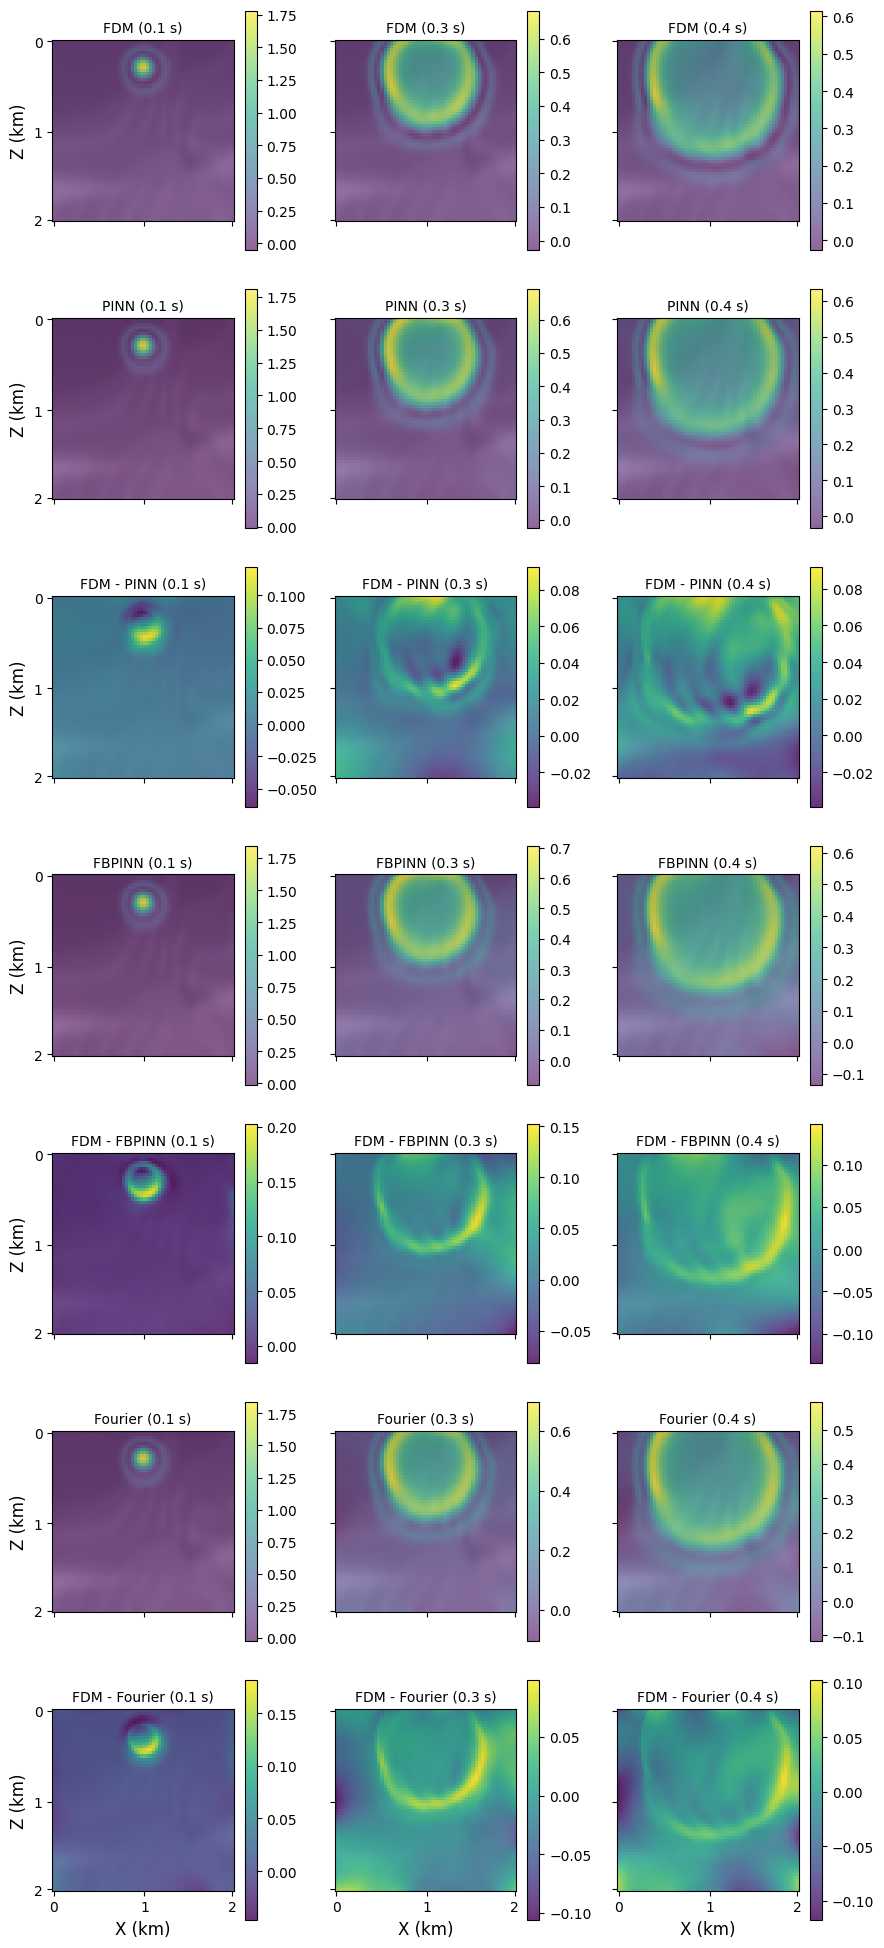

In [279]:
# Example usage:
 
plot_seismic_slices_extended(pinn, fbpinn, fourier, u_marm, pinn3,save_path="./mar_improved.png",dpi=1200)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import time

def run_seismic_simulation_src(
        grid_x, grid_y, time_steps, dx, dy, dt, pml_points,
        vel, rho, initial_pressure, dtype=np.float32,dom_freq=100 ,
        save_wavefields=True, gather_points=None, source=None, source_location=None):
    """
    Run 2D Seismic Simulation using Convolutional Perfectly Matched Layer (CPML)

    Parameters:
        grid_x, grid_y: Grid size in x and y directions
        time_steps: Number of time steps
        dx, dy: Grid spacing in x and y directions
        dt: Time step size
        pml_points: Number of points in the PML region
        vel: Velocity field
        rho: Density field
        initial_pressure: Tuple of initial pressures (past, present)
        dtype: Data type to use
        save_wavefields: Whether to save wavefields during simulation
        gather_points: Indices to gather time series from specific locations
        source: Function that provides source term (should accept time step and return scalar or 2D array)
                or a pre-calculated 3D array of shape (time_steps, grid_x, grid_y)
        source_location: Tuple (x, y) specifying the location of the source
    """

    # Convert input arrays to desired data type
    vel = vel.astype(dtype)
    rho = rho.astype(dtype)

    if gather_points is not None:
        gather_output = True
    else:
        gather_output = False

    # Constants for PML damping
    max_k = 1.0
    alpha_max = 2.0 * np.pi * (dom_freq / 2.0)  # From Festa and Vilotte, using dominant frequency of 20 Hz
    power = 2.0
    reflection_coeff = 0.001
    stability_limit = 1e25

    # Stability Check
    courant = np.max(vel) * dt * np.sqrt(1 / (dx ** 2) + 1 / (dy ** 2))
    if courant > 1.0:
        raise Exception(f"ERROR: Unstable time step, Courant number is {courant:.2f}")

    # Initialize damping profiles
    damping_profiles = get_dampening_profiles(vel, pml_points, reflection_coeff, max_k, alpha_max, power, dt, (dx, dy), dtype)
    [a_x, a_x_half, b_x, b_x_half, k_x, k_x_half], [a_y, a_y_half, b_y, b_y_half, k_y, k_y_half] = damping_profiles

    # Initialize arrays for the simulation
    bulk_modulus = rho * (vel ** 2)
    pressure_curr = initial_pressure[1].astype(dtype)
    pressure_prev = initial_pressure[0].astype(dtype)

    # Memory arrays for derivatives in PML
    mem_dpressure_dx = np.zeros((grid_x, grid_y), dtype=dtype)
    mem_dpressure_dy = np.zeros((grid_x, grid_y), dtype=dtype)
    mem_dpressure_xx = np.zeros((grid_x, grid_y), dtype=dtype)
    mem_dpressure_yy = np.zeros((grid_x, grid_y), dtype=dtype)

    # Output arrays
    if save_wavefields:
        wavefields = np.zeros((time_steps, grid_x, grid_y), dtype=dtype)
    if gather_output:
        gather = np.zeros((gather_points.shape[0], time_steps), dtype=dtype)

    # Density at half-grid points
    rho_half_x = np.pad(0.5 * (rho[1:grid_x, :] + rho[:grid_x - 1, :]), [[0, 1], [0, 0]], mode="edge")
    rho_half_y = np.pad(0.5 * (rho[:, 1:grid_y] + rho[:, :grid_y - 1]), [[0, 0], [0, 1]], mode="edge")

    # Run simulation
    start_time = time.time()
    if source_location is None:
        source_x, source_y = grid_x // 3, grid_y // 3  # Default source location at the center of the grid
    else:
        source_x, source_y = source_location

    for t in range(time_steps):
        # Compute first-order spatial derivatives
        dpressure_dx = np.pad((pressure_curr[1:grid_x, :] - pressure_curr[:grid_x - 1, :]) / dx, [[0, 1], [0, 0]], mode="constant")
        dpressure_dy = np.pad((pressure_curr[:, 1:grid_y] - pressure_curr[:, :grid_y - 1]) / dy, [[0, 0], [0, 1]], mode="constant")

        # Apply PML damping
        mem_dpressure_dx = b_x_half * mem_dpressure_dx + a_x_half * dpressure_dx
        mem_dpressure_dy = b_y_half * mem_dpressure_dy + a_y_half * dpressure_dy

        dpressure_dx = dpressure_dx / k_x_half + mem_dpressure_dx
        dpressure_dy = dpressure_dy / k_y_half + mem_dpressure_dy

        # Divide by density at half points
        pressure_xx = dpressure_dx / rho_half_x
        pressure_yy = dpressure_dy / rho_half_y

        # Compute second-order spatial derivatives
        dpressure_xx_dx = np.pad((pressure_xx[1:grid_x, :] - pressure_xx[:grid_x - 1, :]) / dx, [[1, 0], [0, 0]], mode="constant")
        dpressure_yy_dy = np.pad((pressure_yy[:, 1:grid_y] - pressure_yy[:, :grid_y - 1]) / dy, [[0, 0], [1, 0]], mode="constant")

        # Apply PML damping to second derivatives
        mem_dpressure_xx = b_x * mem_dpressure_xx + a_x * dpressure_xx_dx
        mem_dpressure_yy = b_y * mem_dpressure_yy + a_y * dpressure_yy_dy

        dpressure_xx_dx = dpressure_xx_dx / k_x + mem_dpressure_xx
        dpressure_yy_dy = dpressure_yy_dy / k_y + mem_dpressure_yy

        # Time evolution scheme
        pressure_next = -pressure_prev + 2 * pressure_curr + dt ** 2 * (dpressure_xx_dx + dpressure_yy_dy) * bulk_modulus

        # Inject source term if provided
        if source is not None:
            if callable(source):
                # If source is a function, use it
                pressure_next[source_x,source_y] += source(t) /(dx * dy) * dt ** 2
            else:
                # If source is an array, use the precomputed value for this time step
                pressure_next += source[t] /(dx * dy) * dt ** 2
    
        # Apply Dirichlet boundary conditions
        pressure_next[0, :] = pressure_next[-1, :] = 0.0
        pressure_next[:, 0] = pressure_next[:, -1] = 0.0

        # Save outputs if required
        if save_wavefields:
            wavefields[t, :, :] = pressure_curr
        if gather_output:
            gather[:, t] = pressure_curr[gather_points[:, 0], gather_points[:, 1]]

        # Stability check
        if np.max(np.abs(pressure_curr)) > stability_limit:
            raise Exception('Simulation became unstable')

        # Update time steps
        pressure_prev, pressure_curr = pressure_curr, pressure_next

        # Print progress every 1000 iterations
        if t % 1000 == 0 and t != 0:
            elapsed_time = (time.time() - start_time) / 1000.0
            print(f"[Step {t}/{time_steps}] {elapsed_time:.2f} s per step")
            start_time = time.time()

    return wavefields if save_wavefields else None, gather if gather_output else None


In [133]:
params = all_params["static"]["problem"]
c0, source = params["c0"], params["source"]
c_fn = params["c_fn"]
sd = all_params["static"]["problem"]["sd"]
(xmin, ymin, tmin), (xmax, ymax, tmax) = np.array(x_batch.min(0)), np.array(x_batch.max(0))
NPOINTS_PML = 10
# get grid spacing
deltax, deltay, deltat = (xmax-xmin)/(batch_shape[0]-1), (ymax-ymin)/(batch_shape[1]-1), (tmax-tmin)/(batch_shape[2]-1)

# get f0, target deltas of FD simulation
f0 =5 # c0/source[:,2].min()# approximate frequency of wave
DELTAX = DELTAY = 1/(f0*10)# target fine sampled deltas
DELTAT = DELTAX / (4*np.sqrt(2)*c0)# target fine sampled deltas
dx, dy, dt = int(np.ceil(deltax/DELTAX)), int(np.ceil(deltay/DELTAY)), int(np.ceil(deltat/DELTAT))# make sure deltas are a multiple of test deltas
DELTAX, DELTAY, DELTAT = deltax/dx, deltay/dy, deltat/dt
NX, NY, NSTEPS = batch_shape[0]*dx-(dx-1), batch_shape[1]*dy-(dy-1), batch_shape[2]*dt-(dt-1)
NX,NY,NSTEPS
DELTAX,DELTAY,DELTAT

(np.float32(0.016949153), np.float32(0.016949153), np.float32(0.0034722222))

In [44]:
source

Array([[-0.5, -0.3,  0.1,  1. ]], dtype=float32)

In [51]:
xx,yy = np.meshgrid(np.linspace(xmin, xmax, NX), np.linspace(ymin, ymax, NY), indexing="ij")# (NX, NY)
x = np.stack([xx.ravel(), yy.ravel()], axis=1)# (n, 2)
exp = np.exp
pi = np.pi
p = np.expand_dims(source, axis=1)# (k, 1, 4)
x = np.expand_dims(x, axis=0)# (1, n, 2)

In [114]:
source

Array([[ 0.3, -0.3,  0.2,  1. ]], dtype=float32)

In [246]:
import numpy as np
import matplotlib.pyplot as plt
import time
import numpy as np
import matplotlib.pyplot as plt
from fbpinns.traditional_solutions.seismic_cpml.seismic_CPML_helper import get_dampening_profiles
def run_seismic_simulation_src(
        grid_x, grid_y, time_steps, dx, dy, dt, pml_points,
        vel, rho, initial_pressure, dtype=np.float32,
        save_wavefields=True, gather_points=None, source=None, source_location=None):
    """
    Run 2D Seismic Simulation using Convolutional Perfectly Matched Layer (CPML)

    Parameters:
        grid_x, grid_y: Grid size in x and y directions
        time_steps: Number of time steps
        dx, dy: Grid spacing in x and y directions
        dt: Time step size
        pml_points: Number of points in the PML region
        vel: Velocity field
        rho: Density field
        initial_pressure: Tuple of initial pressures (past, present)
        dtype: Data type to use
        save_wavefields: Whether to save wavefields during simulation
        gather_points: Indices to gather time series from specific locations
        source: Function that provides source term (should accept time step and return scalar or 2D array)
                or a pre-calculated 3D array of shape (time_steps, grid_x, grid_y)
        source_location: Tuple (x, y) specifying the location of the source
    """

    # Convert input arrays to desired data type
    vel = vel.astype(dtype)
    rho = rho.astype(dtype)

    if gather_points is not None:
        gather_output = True
    else:
        gather_output = False

    # Constants for PML damping
    max_k = 1.0
    alpha_max = 2.0 * np.pi * (5.0 / 2.0)  # From Festa and Vilotte, using dominant frequency of 20 Hz
    power = 2.0
    reflection_coeff = 0.001
    stability_limit = 1e25

    # Stability Check
    courant = np.max(vel) * dt * np.sqrt(1 / (dx ** 2) + 1 / (dy ** 2))
    if courant > 1.0:
        raise Exception(f"ERROR: Unstable time step, Courant number is {courant:.2f}")

    # Initialize damping profiles
    damping_profiles = get_dampening_profiles(vel, pml_points, reflection_coeff, max_k, alpha_max, power, dt, (dx, dy), dtype)
    [a_x, a_x_half, b_x, b_x_half, k_x, k_x_half], [a_y, a_y_half, b_y, b_y_half, k_y, k_y_half] = damping_profiles

    # Initialize arrays for the simulation
    bulk_modulus = rho * (vel ** 2)
    pressure_curr = initial_pressure[1].astype(dtype)
    pressure_prev = initial_pressure[0].astype(dtype)

    # Memory arrays for derivatives in PML
    mem_dpressure_dx = np.zeros((grid_x, grid_y), dtype=dtype)
    mem_dpressure_dy = np.zeros((grid_x, grid_y), dtype=dtype)
    mem_dpressure_xx = np.zeros((grid_x, grid_y), dtype=dtype)
    mem_dpressure_yy = np.zeros((grid_x, grid_y), dtype=dtype)

    # Output arrays
    if save_wavefields:
        wavefields = np.zeros((time_steps, grid_x, grid_y), dtype=dtype)
    if gather_output:
        gather = np.zeros((gather_points.shape[0], time_steps), dtype=dtype)

    # Density at half-grid points
    rho_half_x = np.pad(0.5 * (rho[1:grid_x, :] + rho[:grid_x - 1, :]), [[0, 1], [0, 0]], mode="edge")
    rho_half_y = np.pad(0.5 * (rho[:, 1:grid_y] + rho[:, :grid_y - 1]), [[0, 0], [0, 1]], mode="edge")

    # Run simulation
    start_time = time.time()
    if source_location is None:
        source_x, source_y = grid_x // 2, grid_y // 2  # Default source location at the center of the grid
    else:
        source_x, source_y = source_location

    for t in range(time_steps):
        # Compute first-order spatial derivatives
        dpressure_dx = np.pad((pressure_curr[1:grid_x, :] - pressure_curr[:grid_x - 1, :]) / dx, [[0, 1], [0, 0]], mode="constant")
        dpressure_dy = np.pad((pressure_curr[:, 1:grid_y] - pressure_curr[:, :grid_y - 1]) / dy, [[0, 0], [0, 1]], mode="constant")

        # Apply PML damping
        mem_dpressure_dx = b_x_half * mem_dpressure_dx + a_x_half * dpressure_dx
        mem_dpressure_dy = b_y_half * mem_dpressure_dy + a_y_half * dpressure_dy

        dpressure_dx = dpressure_dx / k_x_half + mem_dpressure_dx
        dpressure_dy = dpressure_dy / k_y_half + mem_dpressure_dy

        # Divide by density at half points
        pressure_xx = dpressure_dx / rho_half_x
        pressure_yy = dpressure_dy / rho_half_y

        # Compute second-order spatial derivatives
        dpressure_xx_dx = np.pad((pressure_xx[1:grid_x, :] - pressure_xx[:grid_x - 1, :]) / dx, [[1, 0], [0, 0]], mode="constant")
        dpressure_yy_dy = np.pad((pressure_yy[:, 1:grid_y] - pressure_yy[:, :grid_y - 1]) / dy, [[0, 0], [1, 0]], mode="constant")

        # Apply PML damping to second derivatives
        mem_dpressure_xx = b_x * mem_dpressure_xx + a_x * dpressure_xx_dx
        mem_dpressure_yy = b_y * mem_dpressure_yy + a_y * dpressure_yy_dy

        dpressure_xx_dx = dpressure_xx_dx / k_x + mem_dpressure_xx
        dpressure_yy_dy = dpressure_yy_dy / k_y + mem_dpressure_yy

        # Time evolution scheme
        pressure_next = -pressure_prev + 2 * pressure_curr + dt ** 2 * (dpressure_xx_dx + dpressure_yy_dy) * bulk_modulus

        # Inject source term if provided
        if source is not None:
            if callable(source):
                # If source is a function, use it
                pressure_next[source_x,source_y] += source(t) /(dx * dy) * dt ** 2
            else:
                # If source is an array, use the precomputed value for this time step
                pressure_next += source[t] * (dt)**2 
                
    
        # Apply Dirichlet boundary conditions
        pressure_next[0, :] = pressure_next[-1, :] = 0.0
        pressure_next[:, 0] = pressure_next[:, -1] = 0.0

        # Save outputs if required
        if save_wavefields:
            wavefields[t, :, :] = -5*pressure_curr
        if gather_output:
            gather[:, t] = pressure_curr[gather_points[:, 0], gather_points[:, 1]]

        # Stability check
        if np.max(np.abs(pressure_curr)) > stability_limit:
            raise Exception('Simulation became unstable')

        # Update time steps
        pressure_prev, pressure_curr = pressure_curr, pressure_next

        # Print progress every 1000 iterations
        if t % 1000 == 0 and t != 0:
            elapsed_time = (time.time() - start_time) / 1000.0
            print(f"[Step {t}/{time_steps}] {elapsed_time:.2f} s per step")
            start_time = time.time()

    return wavefields if save_wavefields else None, gather if gather_output else None


[INFO] 2024-12-12 22:52:07 - Running seismicCPML2D (119, 119, 289)..


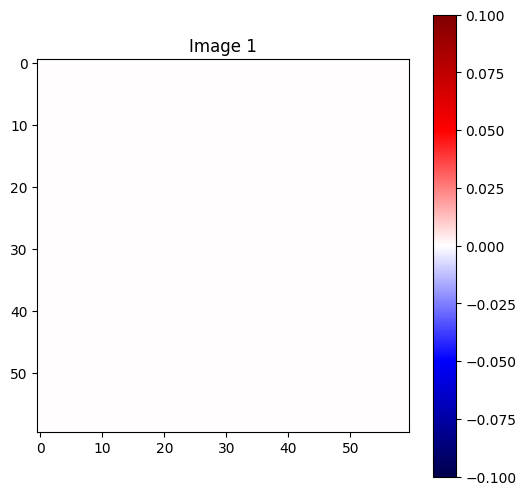

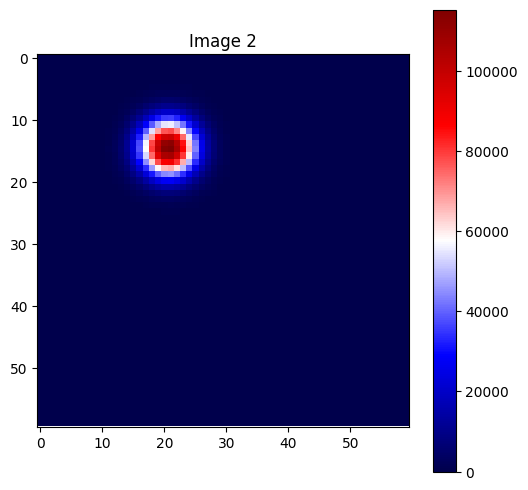

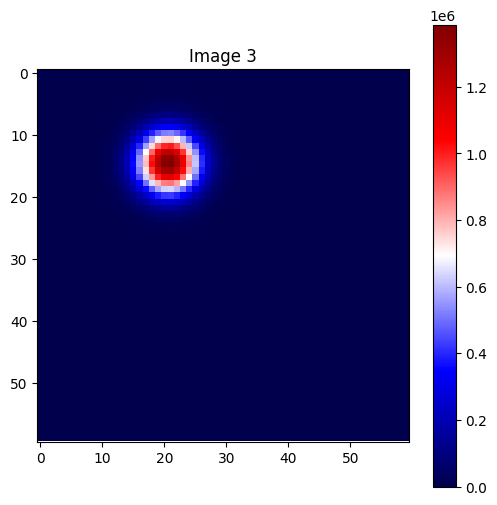

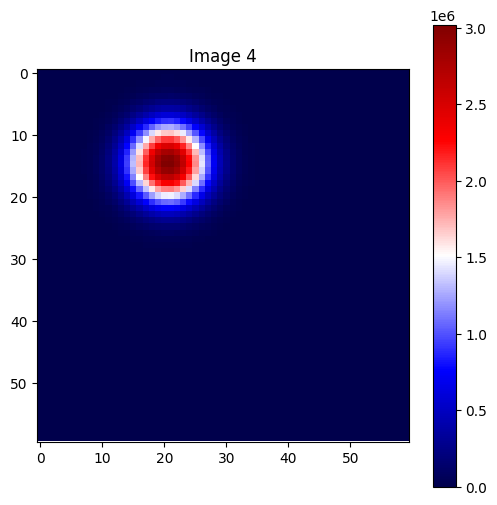

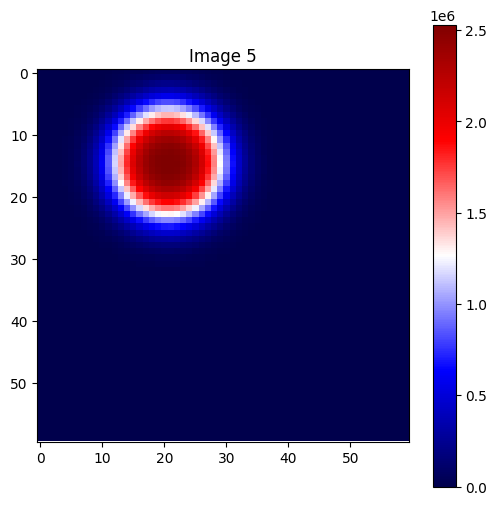

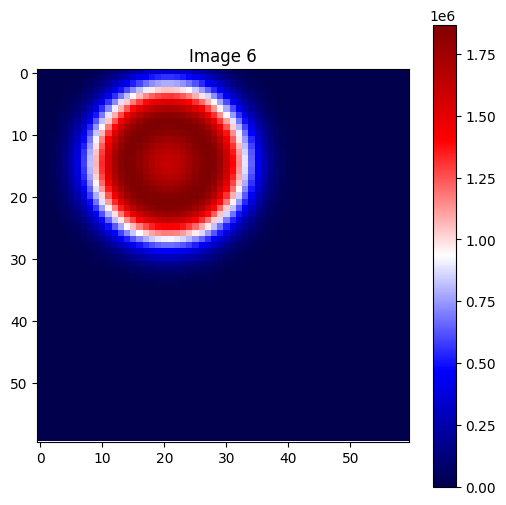

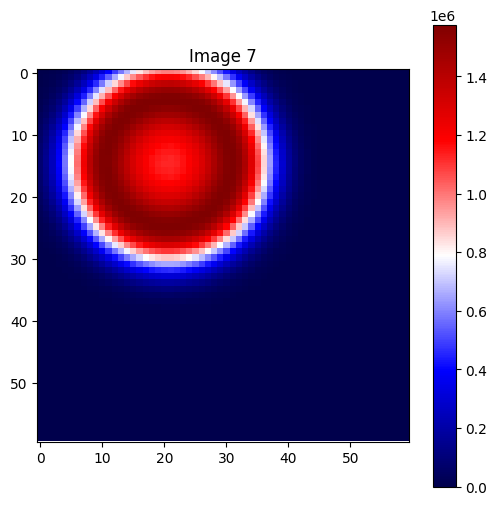

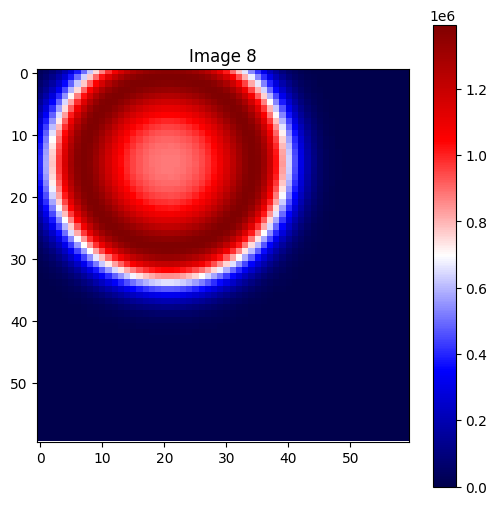

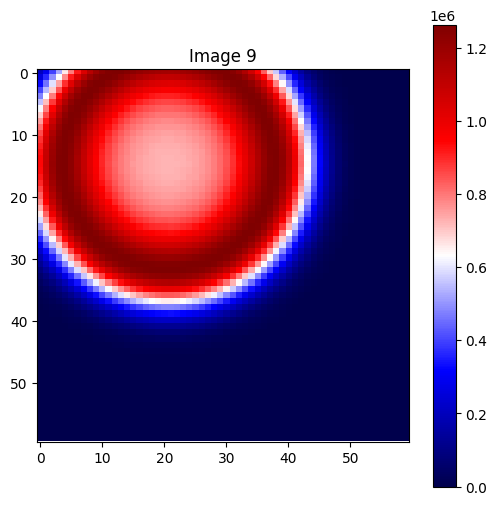

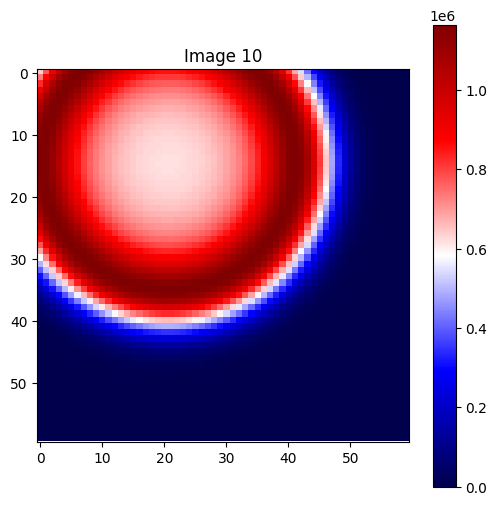

In [165]:

#the ricker source
#xx,yy,tt= np.meshgrid(np.linspace(xmin, xmax, NX), np.linspace(ymin, ymax, NY),np.linspace(tmin, tmax, NSTEPS), indexing="ij")# (NX, NY)

#e = -0.5*((xx+0.75)**2 + (yy-0)**2 + tt**2)/(sd**2)
#s = 2e3*(1+e)*np.exp(e)# ricker source term
 
p0_ = np.zeros((NX,NY))

  # get velocity model
 



density = 1.0 * np.ones((NX, NY))
vel = 3.0 * np.ones((NX,NY))

# add padded CPML boundary
NPOINTS_PML = 10
p0_ = np.pad(p0_, [(NPOINTS_PML,NPOINTS_PML),(NPOINTS_PML,NPOINTS_PML)], mode="edge")
vel=   np.pad(vel, [(NPOINTS_PML,NPOINTS_PML),(NPOINTS_PML,NPOINTS_PML)], mode="edge")
density =  np.pad(density, [(NPOINTS_PML,NPOINTS_PML),(NPOINTS_PML,NPOINTS_PML)], mode="edge")
source_array =  np.pad(src, [(0, 0), (NPOINTS_PML,NPOINTS_PML), (NPOINTS_PML, NPOINTS_PML)], mode='constant')
# run simulation
logger.info(f'Running seismicCPML2D {(NX, NY, NSTEPS)}..')

wavefields,_ = run_seismic_simulation_src(
NX+2*NPOINTS_PML, NY+2*NPOINTS_PML, NSTEPS, DELTAX, DELTAY, DELTAT, NPOINTS_PML,
np.ones((NX+2*NPOINTS_PML,NY+2*NPOINTS_PML)),  vel, (p0_.copy(),p0_.copy()),  
save_wavefields=True, gather_points=None, source=source_array)

# get croped, decimated, flattened wavefields
wavefields = wavefields[:,NPOINTS_PML:-NPOINTS_PML,NPOINTS_PML:-NPOINTS_PML]
wavefields = wavefields[::dt, ::dx, ::dy]
wavefields = np.moveaxis(wavefields, 0, -1)
assert wavefields.shape == batch_shape
u = wavefields.reshape((-1, 1))
u = u.reshape(batch_shape)

# Plotting the 10 images (slices along the third dimension)
for i in range(10):
    plt.figure(figsize=(6, 6))
    plt.imshow(u[:, :, i], cmap='seismic')
    plt.title(f'Image {i + 1}')
    plt.colorbar()
    plt.show()

In [19]:
def extract_from_npz(npz_path, nx, ny, nt=1, for_pinn=True):
    
    # Load data from the .npz file
    data = np.load(npz_path)
    x = data['x']
    y = data['y']
    velocity = data['velocity']
    velocity = iterative_gaussian_smoothing(velocity, 5,50)
     

    # Resample the velocity field using nx and ny
    x_indices = np.linspace(-1, 1, nx, dtype=int)
    y_indices = np.linspace(-1, 1, ny, dtype=int)
    velocity_resampled = velocity[np.ix_(y_indices, x_indices)]
    x_resampled = x[x_indices]
    y_resampled = y[y_indices]

    if for_pinn:
        # Repeat along the temporal axis to create a 3D field
        velocity_temporal = np.repeat(velocity_resampled[:, :, np.newaxis], nt, axis=2)
        # Flatten into a 1D array and reshape for PINN input
        velocity_pinn = velocity_temporal.flatten()[:, np.newaxis]
        return velocity_pinn
    else:
        # Return the resampled 2D array for FDM
        return velocity_resampled 

# Example Usage
npz_path = './marmousi_combined.npz'
pinn_velocity = extract_from_npz(npz_path, nx=80, ny=80, nt=80, for_pinn=True)
fdm_velocity  = extract_from_npz(npz_path, nx=119, ny=119, for_pinn=False)

# Display shapes to verify
pinn_velocity.shape, fdm_velocity.shape


((512000, 1), (119, 119))

In [20]:
from scipy.ndimage import gaussian_filter
import numpy as np

def iterative_gaussian_smoothing(velocity, sigma=1, iterations=5):
    """
    Iteratively applies Gaussian smoothing to a 2D velocity field.

    Parameters:
        velocity (np.ndarray): The original 2D velocity field.
        sigma (float): Standard deviation for the Gaussian kernel.
        iterations (int): Number of times to apply the smoothing.

    Returns:
        np.ndarray: Smoothed velocity field after the specified number of iterations.
    """
    smoothed_velocity = velocity.copy()
    for i in range(iterations):
        smoothed_velocity = gaussian_filter(smoothed_velocity, sigma=sigma)
    return smoothed_velocity
    
 

In [21]:
import numpy as np
from scipy.interpolate import RectBivariateSpline

def resample_velocity_field(file_path, nx, ny, nt=None):
    """
    Resamples a velocity field from an .npy or .npz file to the specified dimensions.
    
    Parameters:
        file_path (str): Path to the .npy or .npz file containing the velocity field.
        nx (int): Number of grid points in the X dimension.
        ny (int): Number of grid points in the Y dimension.
        nt (int, optional): Number of copies to stack along a new dimension. If None, returns a 2D array.
    
    Returns:
        resampled_velocity (np.ndarray): Resampled velocity field (nx x ny) or (nx x ny x nt).
    """
    # Load the velocity model based on the file extension
    if file_path.endswith('.npz'):
        velocity_model = np.load(file_path)['velocity']  # Load 'velocity' key for .npz files
    else:  # Assume .npy
        velocity_model = np.load(file_path)
    
    # Optional: Apply smoothing if needed
    velocity_model = iterative_gaussian_smoothing(velocity_model, 4, 10)
    
    # Original grid for the velocity model
    original_x = np.linspace(0, 1, velocity_model.shape[1])
    original_y = np.linspace(0, 1, velocity_model.shape[0])
    
    # Interpolator
    interpolator = RectBivariateSpline(original_y, original_x, velocity_model)
    
    # Define target grids
    target_x = np.linspace(0, 1, nx)
    target_y = np.linspace(0, 1, ny)
    
    # Resample to nx x ny
    resampled_velocity_2d = interpolator(target_y, target_x)
    
    # If nt is specified, stack along a new dimension
    if nt is not None:
        resampled_velocity = np.stack([resampled_velocity_2d] * nt, axis=2)
    else:
        resampled_velocity = resampled_velocity_2d
    
    return resampled_velocity

# Example usage
fdmv = resample_velocity_field('./vmodel8.npy', 60, 60)  # Resample to 60x60
pinnv = resample_velocity_field('./vmodel8.npy', 80, 80, 80).flatten().reshape(-1, 1)  # Resample to 80x80x80 and flatten


In [24]:
fdmv.size

3600

In [282]:
pinn1 = c_  # Returns 80x80x80 array
pinn2 = resample_velocity_field('./vmodel8.npy', 80, 80, 80).flatten().reshape(-1,1)  # Returns 80x80x80 array
pinn3 = resample_velocity_field('./marmousi_combined.npz', 80, 80, 80).flatten().reshape(-1,1)  # Returns 80x80x80 array


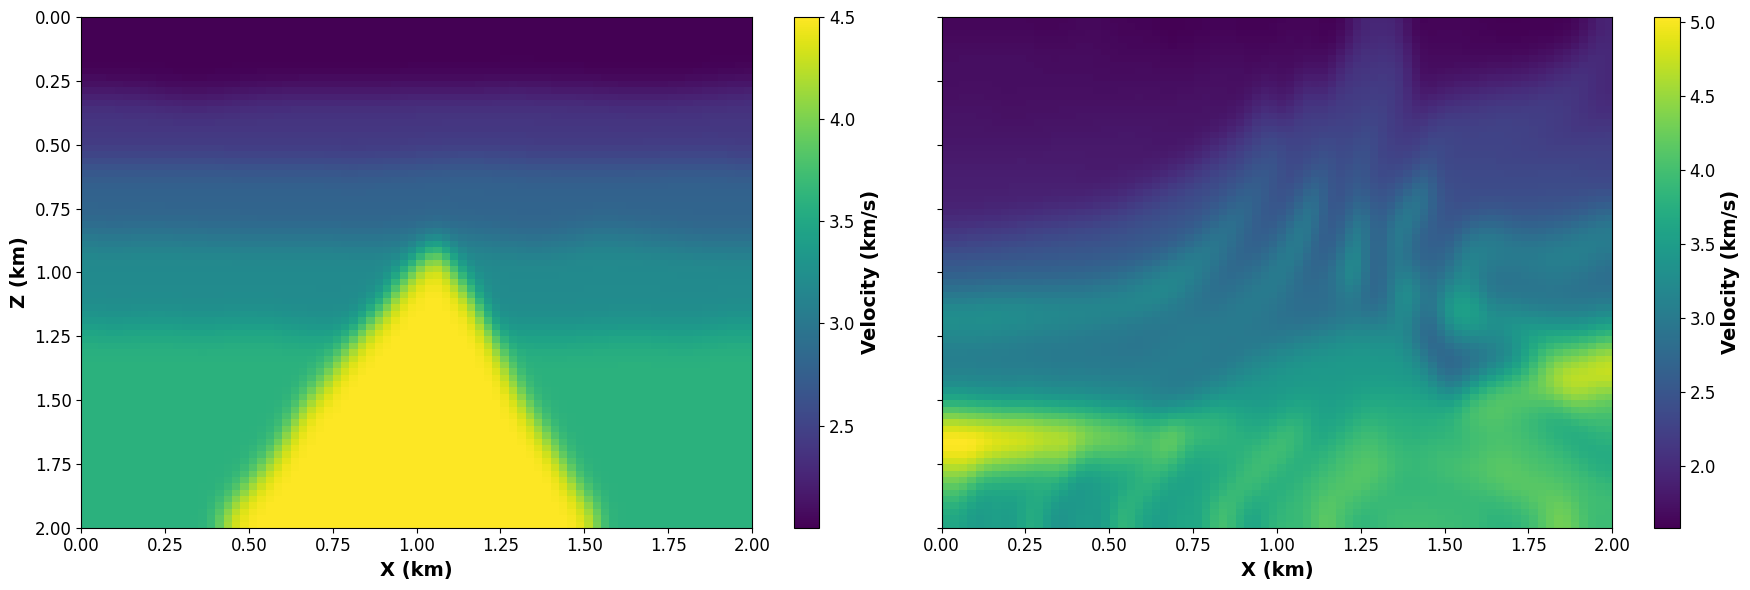

In [284]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming pinn1, pinn2, pinn3 are 3D arrays with shape (80, 80, 80)
# Replace these with your actual data
#velocity_field1 = pinn1.reshape(80, 80, 80)[:, :, 0]
velocity_field2 = pinn2.reshape(80, 80, 80)[:, :, 0] / 1000
velocity_field3 = pinn3.reshape(80, 80, 80)[:, :, 0]

# Define grid spacing and physical distances
grid_spacing = 2.0 / 80  # km
x = np.linspace(0, 2.0, 80)  # X-axis in km
z = np.linspace(0, 2.0, 80)  # Z-axis in km

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Plot each velocity field
fields = [velocity_field2, velocity_field3]
for i, ax in enumerate(axes):
    im = ax.imshow(fields[i], cmap='viridis', aspect='auto', extent=[x[0], x[-1], z[-1], z[0]])
    ax.set_xlabel('X (km)', fontsize=14, fontweight='bold')
    if i == 0:  # Add y-axis label to the first subplot
        ax.set_ylabel('Z (km)', fontsize=14, fontweight='bold')
    # Add individual colorbars
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Velocity (km/s)', fontsize=14, fontweight='bold')
    cbar.ax.tick_params(labelsize=12)

    # Format ticks
    ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust layout for better appearance
plt.tight_layout()
plt.savefig("./velmodels_Only2.png", format='png', dpi=600, bbox_inches='tight')
plt.show()
